# 0. Imports

In [25]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

# 1. Dataset object

## 1.1 Normal dataset for lung images

In [2]:
class Lung_Dataset(Dataset):
    """
    Generic Dataset class.
    """
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Three classes will be considered here (normal, infected and covid)
        self.classes = {0: 'normal', 1: 'infected', 2: 'covid'}
        
        # The dataset has been split in training, testing and validation datasets
        self.groups = ['train', 'test', 'val']
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'train_normal': 1341,\
                                'train_infected': 2530,\
                                'train_covid': 1345, \
                                'val_normal': 8,\
                                'val_infected': 8,\
                                'val_covid': 8, \
                                'test_normal': 234,\
                                'test_infected': 242, \
                                'test_covid': 138}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_normal': './dataset/train/normal/',\
                              'train_infected': './dataset/train/infected/non-covid/',\
                              'train_covid': './dataset/train/infected/covid/', \
                              'val_normal': './dataset/val/normal/',\
                              'val_infected': './dataset/val/infected/non-covid/',\
                              'val_covid': './dataset/val/infected/covid/', \
                              'test_normal': './dataset/test/normal/',\
                              'test_infected': './dataset/test/infected/non-covid/', \
                              'test_covid': './dataset/train/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the Lung Dataset used for the Small Project in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "Images have been split in three groups: training, testing and validation sets.\n"
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            # Convert to Numpy array and normalize pixel values by dividing by 255.
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)

## 1.2 Train dataset

In [8]:
class Lung_Train_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Three classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'infected', 2: 'covid'}
        
        # The dataset consists only of training images
        self.groups = 'train'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'train_normal': 1341,\
                                'train_infected': 2530, \
                                'train_covid': 1345}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_normal': './dataset/train/normal/',\
                              'train_infected': './dataset/train/infected/non-covid', \
                              'train_covid': './dataset/train/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the training dataset of the Lung Dataset"
        msg += " used for the Small Project in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected' or 'covid'"
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = first_val + int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index >= first_val and index < second_val:
            class_val = 'infected'
            index = index - first_val
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = 'covid'
            index = index - second_val
            label = torch.Tensor([0, 0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

In [9]:
ld_train = Lung_Train_Dataset()
ld_train.describe()

This is the training dataset of the Lung Dataset used for the Small Project in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 5216 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset/train/normal/: 1341 images.
 - train_infected, in folder ./dataset/train/infected/non-covid: 2530 images.
 - train_covid, in folder ./dataset/train/infected/covid/: 1345 images.



In [10]:
print(len(ld_train))

5216


In [11]:
im, class_oh = ld_train[64]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([1., 0., 0.])


## 1.3 Test dataset

In [12]:
class Lung_Test_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Three classes will be considered here (normal, infected and covid)
        self.classes = {0: 'normal', 1: 'infected', 2: 'covid'}
        
        # The dataset consists only of test images
        self.groups = 'test'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'test_normal': 234,\
                                'test_infected': 242, \
                                'test_covid': 138}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'test_normal': './dataset/test/normal/',\
                              'test_infected': './dataset/test/infected/non-covid', \
                              'test_covid': './dataset/test/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the test dataset of the Lung Dataset"
        msg += " used for the Small Project in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected' or 'covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = first_val + int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index >= first_val and index < second_val:
            class_val = 'infected'
            index = index - first_val
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = 'covid'
            index = index - second_val
            label = torch.Tensor([0, 0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

In [13]:
ld_test = Lung_Test_Dataset()
ld_test.describe()

This is the test dataset of the Lung Dataset used for the Small Project in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 614 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - test_normal, in folder ./dataset/test/normal/: 234 images.
 - test_infected, in folder ./dataset/test/infected/non-covid: 242 images.
 - test_covid, in folder ./dataset/test/infected/covid/: 138 images.



In [14]:
print(len(ld_test))

614


In [15]:
im, class_oh = ld_test[18]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.0118, 0.0118, 0.0118,  ..., 0.0235, 0.0235, 0.0196],
         [0.0118, 0.0118, 0.0118,  ..., 0.0235, 0.0235, 0.0196],
         [0.0118, 0.0118, 0.0118,  ..., 0.0235, 0.0235, 0.0196],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0196, 0.0157],
         [0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0196, 0.0157],
         [0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0196, 0.0157]]])
tensor([1., 0., 0.])


## 1.4 Validation dataset

In [16]:
class Lung_Val_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Three classes will be considered here (normal, infected and covid)
        self.classes = {0: 'normal', 1: 'infected', 2: 'covid'}
        
        # The dataset consists only of validation images
        self.groups = 'val'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'val_normal': 8,\
                                'val_infected': 8, \
                                'val_covid': 8}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'val_normal': './dataset/val/normal/',\
                              'val_infected': './dataset/val/infected/non-covid/', \
                              'val_covid': './dataset/val/infected/covid'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the validation dataset of the Lung Dataset"
        msg += " used for the Small Project in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected' or 'covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = first_val + int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index >= first_val and index < second_val:
            class_val = 'infected'
            index = index - first_val
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = 'covid'
            index = index - second_val
            label = torch.Tensor([0, 0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

In [17]:
ld_val = Lung_Val_Dataset()
ld_val.describe()

This is the validation dataset of the Lung Dataset used for the Small Project in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 24 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - val_normal, in folder ./dataset/val/normal/: 8 images.
 - val_infected, in folder ./dataset/val/infected/non-covid/: 8 images.
 - val_covid, in folder ./dataset/val/infected/covid: 8 images.



In [18]:
print(len(ld_val))

24


In [19]:
im, class_oh = ld_val[3]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.2627, 0.2392, 0.3686,  ..., 0.0863, 0.0784, 0.0588],
         [0.0784, 0.1255, 0.3725,  ..., 0.0745, 0.0745, 0.0627],
         [0.2902, 0.2863, 0.4824,  ..., 0.0745, 0.0824, 0.0667],
         ...,
         [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])
tensor([1., 0., 0.])


# 2. Dataloader object

In [20]:
# Batch size value to be used (to be decided freely, but set to 4 for demo)
bs_val = 4

In [21]:
# Dataloader from dataset (train)
train_loader = DataLoader(ld_train, batch_size = bs_val, shuffle = True)
print(train_loader)

In [22]:
# Dataloader from dataset (test and val)
test_loader = DataLoader(ld_test, batch_size = bs_val, shuffle = True)
print(test_loader)
val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)
print(val_loader)

During the training, you will call for mini-batches using a for loop of some sort, probably similar to the one below.

Notice how each iteration of the for loop below produces a torch tensor of size [1, bs_val, 150, 150] in v[0] containing the bs_val = 4 images in the current mini-batch. You also have, in v[1], a torch tensor of size [bs_val, 2], containing the one hot vectors for each of the bs_val = 4 images.

We voluntarily interrupt it after one iteration of the mini-batch using an assert False.

In [18]:
# Typical mini-batch for loop on dataloader (train)
for k, v in enumerate(train_loader):
    print("-----")
    print(k)
    print(v[0])
    print(v[1])
    # Forced stop
    break
    #assert False, "Forced stop after one iteration of the for loop"

-----
0
tensor([[[[0.1098, 0.1373, 0.1647,  ..., 0.3216, 0.2706, 0.2078],
          [0.1137, 0.1333, 0.1608,  ..., 0.2941, 0.2471, 0.1922],
          [0.1255, 0.1373, 0.1529,  ..., 0.2745, 0.2353, 0.1922],
          ...,
          [0.0275, 0.0078, 0.0039,  ..., 0.0275, 0.0275, 0.0314],
          [0.0275, 0.0157, 0.0157,  ..., 0.0471, 0.0549, 0.0588],
          [0.0118, 0.0039, 0.0118,  ..., 0.0353, 0.0353, 0.0314]]],


        [[[0.2157, 0.2471, 0.2863,  ..., 0.3176, 0.3216, 0.2627],
          [0.2196, 0.2549, 0.2902,  ..., 0.3137, 0.3255, 0.2745],
          [0.2235, 0.2667, 0.2980,  ..., 0.3059, 0.3255, 0.2902],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000]]],


        [[[0.0196, 0.7333, 0.3569,  ..., 0.0980, 0.0549, 0.0549],
          [0.0275, 0.8000, 0.3804,  ..., 0.1647, 0.1255, 0.1137],
          [0.0000, 0.7294, 0.3

In [23]:
# https://github.com/pytorch/examples/tree/master/mnist

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(341056, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
#         print("Input:", x.shape)
        x = self.conv1(x)
#         print("After conv1:", x.shape)
        x = F.relu(x)
        x = self.conv2(x)
#         print("After conv2:", x.shape)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
#         print("After max_pool2d:", x.shape)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
#         print("After flatten:", x.shape)
        x = self.fc1(x)
#         print("After fc1:", x.shape)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
#         print("After fc2:", x.shape)
        output = F.log_softmax(x, dim=1)
#         print("Output:", output.shape)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    print('training now...')
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
#         print(output.long())
#         print(torch.gt(target, 0))
        
        loss = nn.CrossEntropyLoss()
        loss = loss(output, torch.argmax(target, 1))
        
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
#             test_loss += F.nll_loss(output, torch.argmax(target.long(), 1), reduction='sum').item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            test_loss += nn.CrossEntropyLoss()(output, torch.argmax(target.long(), 1)).item()
#             print(f"This is test_loss: {test_loss}")
            pred = output.argmax(dim=1, keepdim=True)
#             print(f"This is pred: {pred}")
#             print(torch.argmax(target, 1))
#             print(pred.eq(torch.argmax(target, 1).view_as(pred)).sum().item())

#             correct += pred.eq(target.view_as(pred)).sum().item()
            correct += pred.eq(torch.argmax(target, 1).view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
#             test_loss += F.nll_loss(output, torch.argmax(target.long(), 1), reduction='sum').item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            val_loss += nn.CrossEntropyLoss()(output, torch.argmax(target.long(), 1)).item()
#             print(f"This is test_loss: {test_loss}")
            pred = output.argmax(dim=1, keepdim=True)
#             print(f"This is pred: {pred}")
#             print(torch.argmax(target, 1))
#             print(pred.eq(torch.argmax(target, 1).view_as(pred)).sum().item())

#             correct += pred.eq(target.view_as(pred)).sum().item()
            correct += pred.eq(torch.argmax(target, 1).view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    
    

def main():
    # Training settings
    class args:
      batch_size = 2 #'input batch size for training (default: 64)')
      test_batch_size = 1000 #'input batch size for testing (default: 1000)')
      epochs = 10 #'number of epochs to train (default: 14)')
      lr = 1.0 #'learning rate (default: 1.0)')
      gamma = 0.7 #'Learning rate step gamma (default: 0.7)')
      no_cuda = False #'disables CUDA training')
      dry_run = False #'quickly check a single pass')
      seed = 1 #'random seed (default: 1)')
      log_interval = 1000 #'how many batches to wait before logging training status')
      save_model = True #'For Saving the current Model')
    
    
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    
    # Dataloader from dataset (train)
    train_loader = DataLoader(ld_train, batch_size = bs_val, shuffle = True)
    
    # Dataloader from dataset (test and val)
    test_loader = DataLoader(ld_test, batch_size = bs_val, shuffle = True)

    val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)

    model = Net().to(device)
    print(model)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        validate(model, device, val_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


main()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=341056, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)
training now...
Train Epoch: 1 [0/5216 (0%)]	Loss: 1.017020
Train Epoch: 1 [4000/5216 (77%)]	Loss: 0.472330

Test set: Average loss: 0.2733, Accuracy: 392/614 (64%)


Test set: Average loss: 0.3128, Accuracy: 10/24 (42%)

training now...
Train Epoch: 2 [0/5216 (0%)]	Loss: 0.672792
Train Epoch: 2 [4000/5216 (77%)]	Loss: 0.493848

Test set: Average loss: 0.3129, Accuracy: 394/614 (64%)


Test set: Average loss: 0.2892, Accuracy: 10/24 (42%)

training now...
Train Epoch: 3 [0/5216 (0%)]	Loss: 0.278954
Train Epoch: 3 [4000/5216 (77%)]	Loss: 0.344125

Test set: Average loss: 0.3717, Accuracy: 404/614 (66%)


Test set: Average loss: 0.2896, Accuracy: 13/24

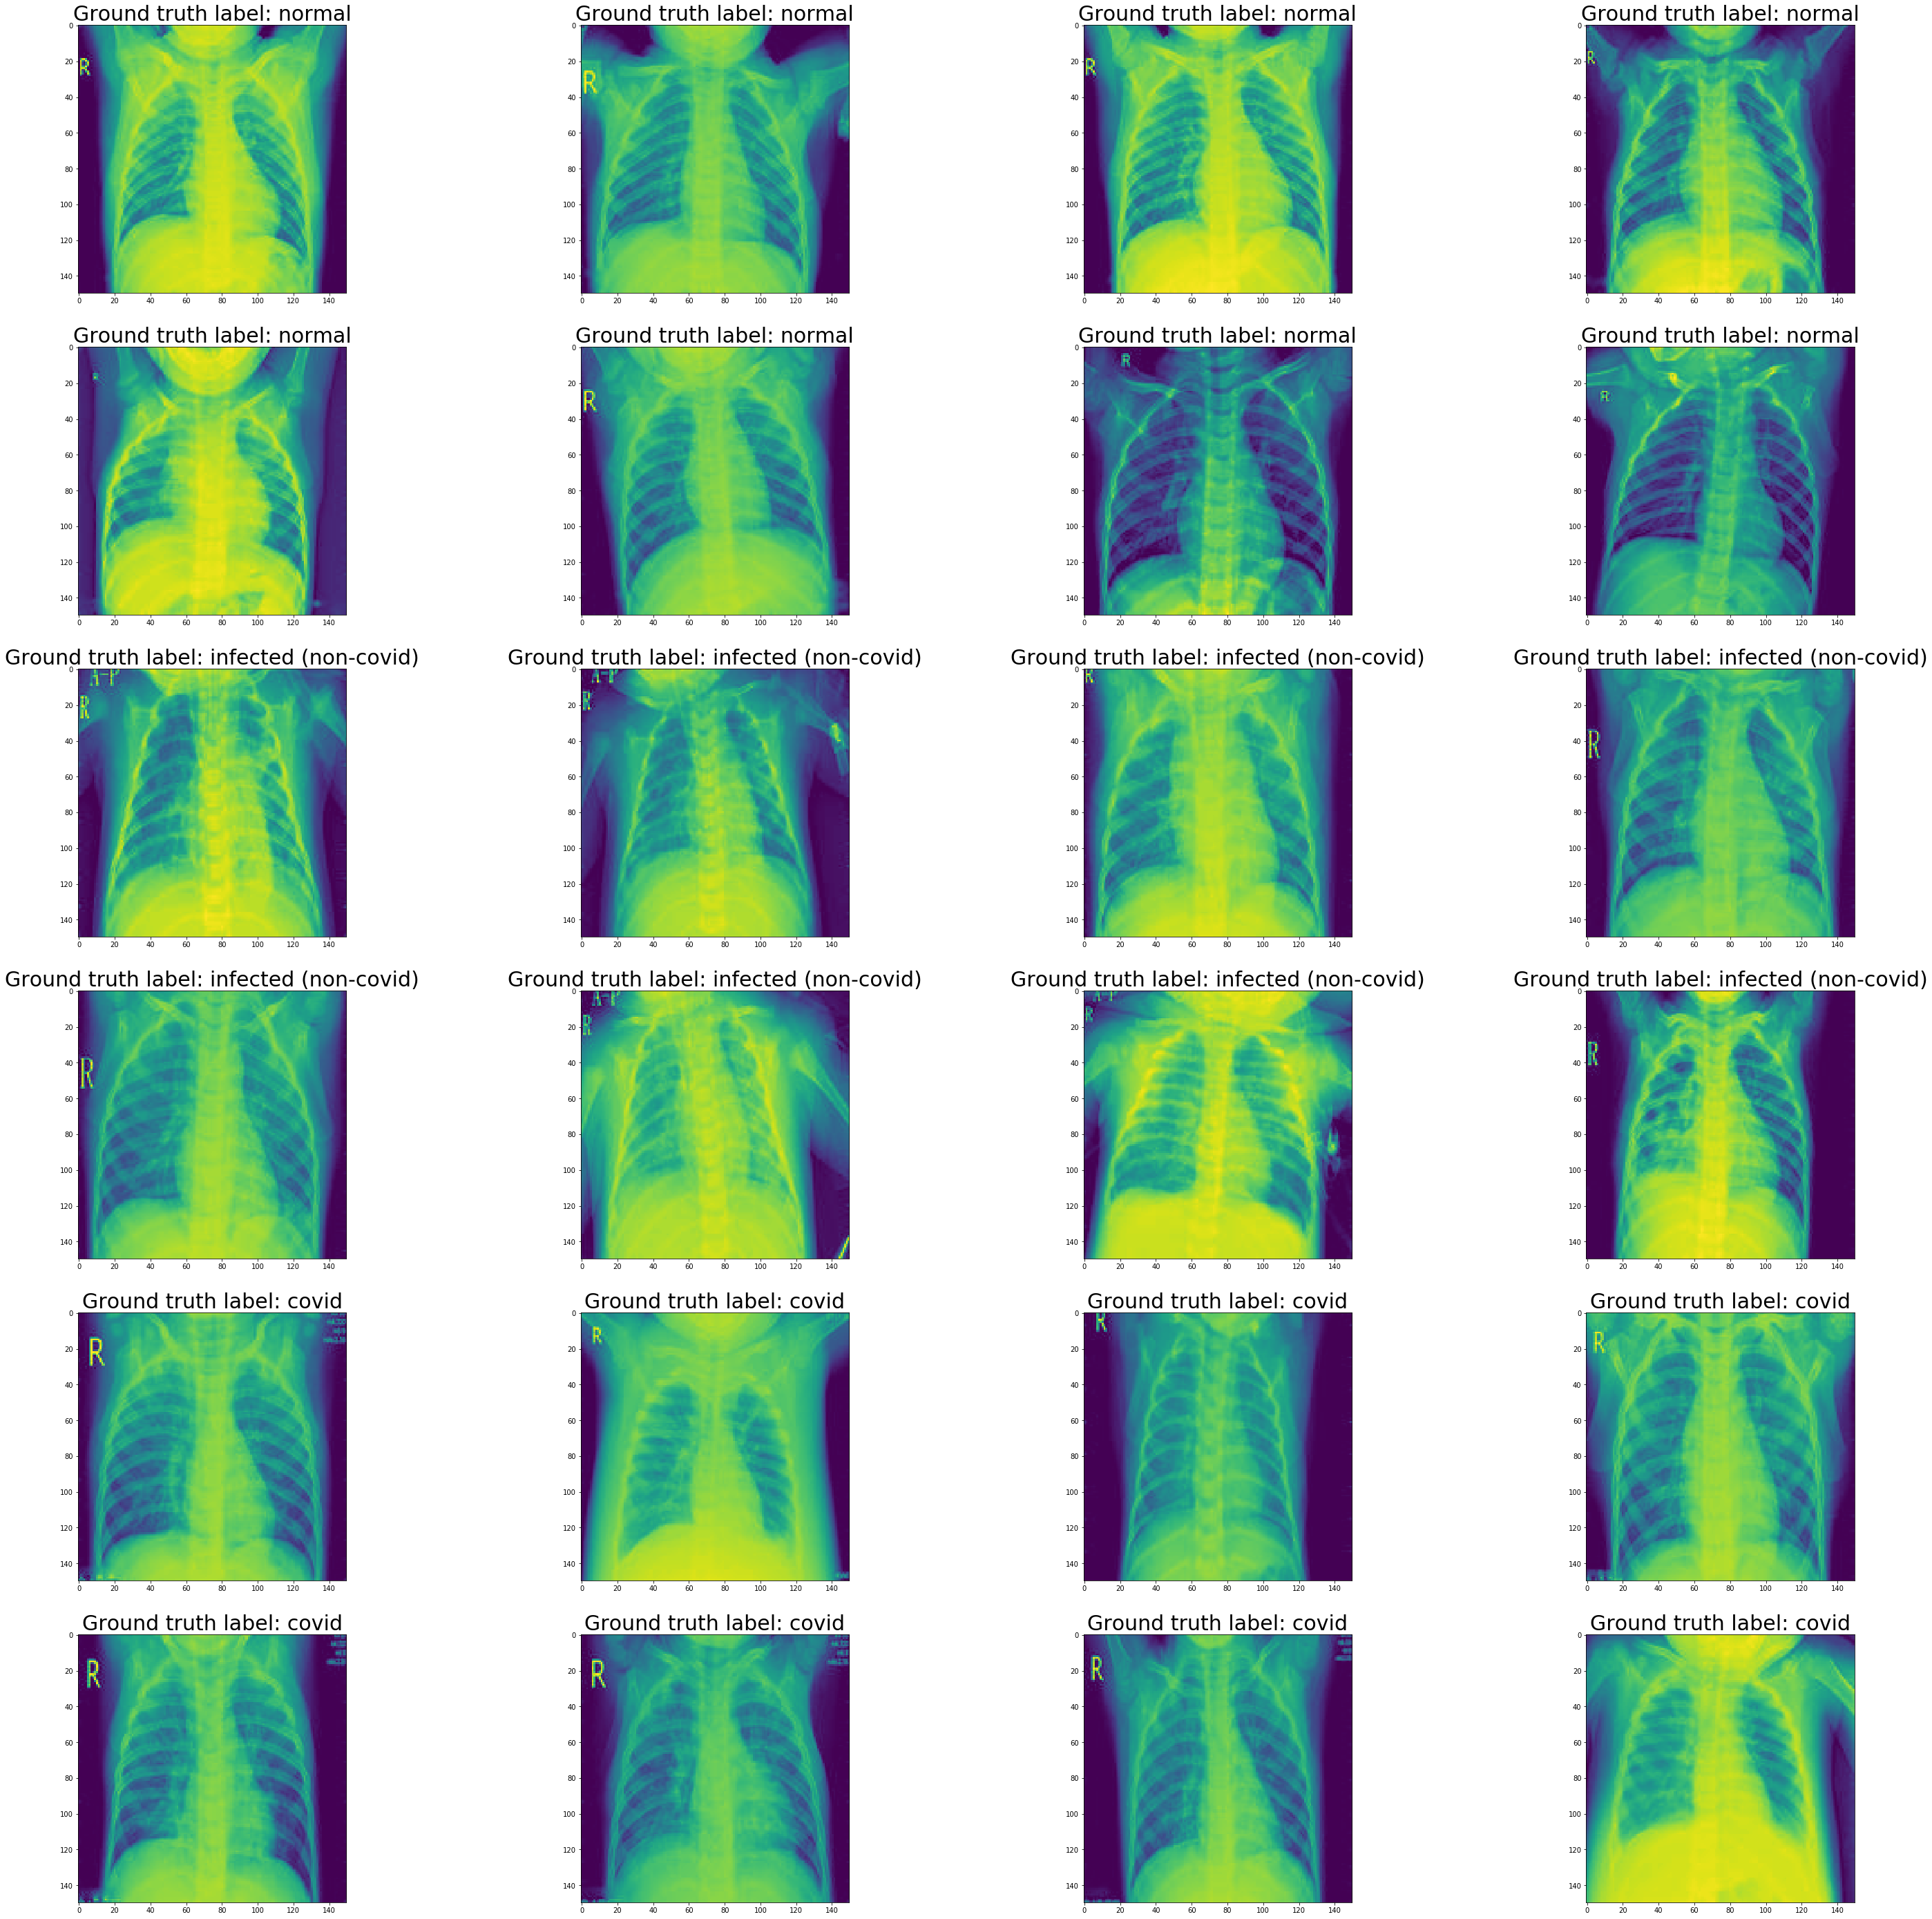

In [124]:

"""Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected' or 'covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
"""


class_val = ["normal","normal","normal","normal","normal","normal","normal","normal",
             "infected (non-covid)","infected (non-covid)","infected (non-covid)","infected (non-covid)","infected (non-covid)","infected (non-covid)","infected (non-covid)","infected (non-covid)",
             "covid","covid","covid","covid","covid","covid","covid","covid"]

f = plt.figure(figsize=(50, 50))

axes = []



for a in range(3 * 8):
    
    classes = class_val[a]
    if classes == "infected (non-covid)":
        x = "infected"
    else:
        x = classes


    axes.append(f.add_subplot(6, 4, a+1))
    
    subplot_title = ("Ground truth label: " + classes)
    axes[-1].set_title(subplot_title, size = 30)
    ld_val.show_img("val", x, a%8)
    

plt.show()
